In [2]:
from numpy import array, save, asarray
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM, Dense, Dropout, GRU
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D
import pickle
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import scikitplot as skplt
from sklearn.metrics import precision_recall_fscore_support



In [1]:
pip install scikit-plot

In [3]:
def split_sequence(sequence, n_steps, classes):
    X, y = [], []
    for i in range(0, len(sequence), n_steps):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = array(classes[i:end_ix])
        if np.sum(seq_y)==0:
            seq_y = 0; # normal
        else:
            seq_y = seq_y[seq_y>0]                 # ignore normal events 
            seq_y = np.argmax (np.bincount(seq_y)) # select most frequent attack
        X.append(seq_x)
        y.append(seq_y) 
    return array(X), array(y)


In [6]:
# load training data
F  = pd.read_csv('/content/drive/My Drive/GrupoEstudiantesAgo-Dic2020/IDS/DataSets/CICDoS2017/Pre-processed/dataTrain.csv')


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
F.columns

Index(['Unnamed: 0', 'Src.IP', 'Src.Port', 'Dst.IP', 'Dst.Port', 'Protocol',
       'Flow.Duration', 'Tot.Fwd.Pkts', 'Tot.Bwd.Pkts', 'TotLen.Fwd.Pkts',
       'TotLen.Bwd.Pkts', 'Fwd.Pkt.Len.Max', 'Fwd.Pkt.Len.Min',
       'Fwd.Pkt.Len.Std', 'Bwd.Pkt.Len.Max', 'Bwd.Pkt.Len.Min',
       'Bwd.Pkt.Len.Std', 'Flow.Byts.s', 'Flow.Pkts.s', 'Flow.IAT.Mean',
       'Flow.IAT.Std', 'Flow.IAT.Max', 'Flow.IAT.Min', 'Fwd.IAT.Mean',
       'Fwd.IAT.Std', 'Fwd.IAT.Min', 'Bwd.IAT.Tot', 'Bwd.IAT.Mean',
       'Bwd.IAT.Std', 'Bwd.IAT.Max', 'Bwd.IAT.Min', 'Fwd.PSH.Flags',
       'Fwd.Pkts.s', 'Bwd.Pkts.s', 'Pkt.Len.Min', 'Pkt.Len.Max',
       'Pkt.Len.Mean', 'Pkt.Len.Std', 'Pkt.Len.Var', 'FIN.Flag.Cnt',
       'SYN.Flag.Cnt', 'RST.Flag.Cnt', 'PSH.Flag.Cnt', 'Down.Up.Ratio',
       'Bwd.Pkts.b.Avg', 'Bwd.Blk.Rate.Avg', 'Subflow.Fwd.Pkts',
       'Subflow.Fwd.Byts', 'Subflow.Bwd.Byts', 'Init.Fwd.Win.Byts',
       'Init.Bwd.Win.Byts', 'Fwd.Seg.Size.Min', 'Idle.Mean', 'Idle.Std',
       'Idle.Min', 'Label']

In [8]:
xtrainlabel = F.loc[:,['Label']].values

xtrain = F.loc[:, ['Flow.Duration', 'Tot.Fwd.Pkts', 'Tot.Bwd.Pkts', 'TotLen.Fwd.Pkts',
       'TotLen.Bwd.Pkts', 'Fwd.Pkt.Len.Max', 'Fwd.Pkt.Len.Min',
       'Fwd.Pkt.Len.Std', 'Bwd.Pkt.Len.Max', 'Bwd.Pkt.Len.Min',
       'Bwd.Pkt.Len.Std', 'Flow.Byts.s', 'Flow.Pkts.s', 'Flow.IAT.Mean',
       'Flow.IAT.Std', 'Flow.IAT.Max', 'Flow.IAT.Min', 'Fwd.IAT.Mean',
       'Fwd.IAT.Std', 'Fwd.IAT.Min', 'Bwd.IAT.Tot', 'Bwd.IAT.Mean',
       'Bwd.IAT.Std', 'Bwd.IAT.Max', 'Bwd.IAT.Min', 'Fwd.PSH.Flags',
       'Fwd.Pkts.s', 'Bwd.Pkts.s', 'Pkt.Len.Min', 'Pkt.Len.Max',
       'Pkt.Len.Mean', 'Pkt.Len.Std', 'Pkt.Len.Var', 'FIN.Flag.Cnt',
       'SYN.Flag.Cnt', 'RST.Flag.Cnt', 'PSH.Flag.Cnt', 'Down.Up.Ratio',
       'Bwd.Pkts.b.Avg', 'Bwd.Blk.Rate.Avg', 'Subflow.Fwd.Pkts',
       'Subflow.Fwd.Byts', 'Subflow.Bwd.Byts', 'Init.Fwd.Win.Byts',
       'Init.Bwd.Win.Byts', 'Fwd.Seg.Size.Min', 'Idle.Mean', 'Idle.Std',
       'Idle.Min']].values

In [9]:
print(xtrain.shape)

(102692, 49)


In [10]:
fit = StandardScaler().fit(xtrain)
xtrain = fit.transform(xtrain)


In [ ]:
joblib.dump(fit, "scaler_cic2017.joblib") 

['scaler_cic2017.joblib']

In [11]:
pca = PCA(.85)
pca.fit(xtrain)
pca.n_components_ 


16

In [ ]:
#xtrain = pca.transform(xtrain)

In [ ]:
joblib.dump(pca, "pca_cic2017.joblib") 

In [12]:
# set number of features
n_features = xtrain.shape[1]
# set number of time steps
n_steps = 5
# split into [samples, timesteps, features]
x_train, y_train = split_sequence(xtrain, n_steps, xtrainlabel)

In [13]:
print(x_train.shape)
print(y_train.shape)

(20538, 5, 49)
(20538,)


In [ ]:
# define parameters
batch_size = 250 # samples per stack
kernel_size= 3
hidden_size = 128
epochs = 100
# define model
model = Sequential()
model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(GRU(100, activation='relu'))
#model.add(Conv1D(filters,kernel_size,padding='valid', activation='relu',strides=1))
#model.add(GlobalMaxPooling1D())
model.add(Dense(150, activation='relu'))
model.add(Dense(hidden_size,activation='relu'))
# model.add(Dense(hidden_size1,activation = 'sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(9,activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
model.fit(x_train, y_train, batch_size, epochs=epochs)
#%%

Epoch 1/100
83/83 [==============================] - 3s 41ms/step - loss: 0.6844 - sparse_categorical_accuracy: 0.8282
Epoch 2/100
83/83 [==============================] - 3s 41ms/step - loss: 0.1994 - sparse_categorical_accuracy: 0.9345
Epoch 3/100
83/83 [==============================] - 3s 41ms/step - loss: 0.1404 - sparse_categorical_accuracy: 0.9523
Epoch 4/100
83/83 [==============================] - 3s 42ms/step - loss: 0.1043 - sparse_categorical_accuracy: 0.9663
Epoch 5/100
83/83 [==============================] - 3s 41ms/step - loss: 0.0914 - sparse_categorical_accuracy: 0.9703
Epoch 6/100
83/83 [==============================] - 3s 42ms/step - loss: 0.0751 - sparse_categorical_accuracy: 0.9760
Epoch 7/100
83/83 [==============================] - 3s 41ms/step - loss: 0.0650 - sparse_categorical_accuracy: 0.9783
Epoch 8/100
83/83 [==============================] - 3s 41ms/step - loss: 0.0595 - sparse_categorical_accuracy: 0.9812
Epoch 9/100
83/83 [=============================

load model

In [14]:
model = load_model('/content/drive/MyDrive/GrupoEstudiantesAgo-Dic2020/IDS/Aplicaciones/Modelling/Best Model Objects/CICDoS2017/gru/GRU_CIC2017')

In [15]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 5, 100)            45300     
_________________________________________________________________
gru_3 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               19328     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 1161      
Total params: 141,539
Trainable params: 141,539
Non-trainable params: 0
________________________________________________

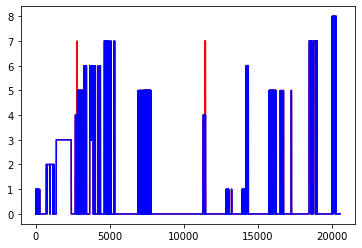

In [ ]:
# demonstrate verify fitting on training
yhat = model.predict(x_train)
yyhat = []
for k in range (0,len(yhat)):
    yh = np.argmax(yhat[k]) # max probability
    yyhat.append(yh)
plt.figure(1)
plt.plot(yyhat,'r', y_train,'b')  


test on training

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
y_pred = model.predict(x_train)
yyhat = []
for k in range (0,len(yhat)):
    yh = np.argmax(yhat[k]) # max probability
    yyhat.append(yh)
accuracy = metrics.accuracy_score(y_train, yyhat)
print(accuracy)
# precision recall and fscore
precision_recall_fscore_support(y_train, yyhat, average='weighted')

0.9997078586035641


(0.9997084025781324, 0.9997078586035641, 0.9997074980738051, None)

In [16]:
# TESTING MODEL WITH NEW DATA
# load testing data
F_test  = pd.read_csv('/content/drive/My Drive/GrupoEstudiantesAgo-Dic2020/IDS/DataSets/CICDoS2017/Pre-processed/dataTest.csv')

y_test = F_test.loc[:,['Label']].values

x_test = F_test.loc[:, ['Flow.Duration', 'Tot.Fwd.Pkts', 'Tot.Bwd.Pkts', 'TotLen.Fwd.Pkts',
       'TotLen.Bwd.Pkts', 'Fwd.Pkt.Len.Max', 'Fwd.Pkt.Len.Min',
       'Fwd.Pkt.Len.Std', 'Bwd.Pkt.Len.Max', 'Bwd.Pkt.Len.Min',
       'Bwd.Pkt.Len.Std', 'Flow.Byts.s', 'Flow.Pkts.s', 'Flow.IAT.Mean',
       'Flow.IAT.Std', 'Flow.IAT.Max', 'Flow.IAT.Min', 'Fwd.IAT.Mean',
       'Fwd.IAT.Std', 'Fwd.IAT.Min', 'Bwd.IAT.Tot', 'Bwd.IAT.Mean',
       'Bwd.IAT.Std', 'Bwd.IAT.Max', 'Bwd.IAT.Min', 'Fwd.PSH.Flags',
       'Fwd.Pkts.s', 'Bwd.Pkts.s', 'Pkt.Len.Min', 'Pkt.Len.Max',
       'Pkt.Len.Mean', 'Pkt.Len.Std', 'Pkt.Len.Var', 'FIN.Flag.Cnt',
       'SYN.Flag.Cnt', 'RST.Flag.Cnt', 'PSH.Flag.Cnt', 'Down.Up.Ratio',
       'Bwd.Pkts.b.Avg', 'Bwd.Blk.Rate.Avg', 'Subflow.Fwd.Pkts',
       'Subflow.Fwd.Byts', 'Subflow.Bwd.Byts', 'Init.Fwd.Win.Byts',
       'Init.Bwd.Win.Byts', 'Fwd.Seg.Size.Min', 'Idle.Mean', 'Idle.Std',
       'Idle.Min']].values


x_test = fit.transform(x_test)

#x_test = pca.transform(x_test)
# split into [samples, timesteps, features]
x_test, y_test = split_sequence(x_test, n_steps, y_test)


In [17]:
print(x_test.shape)
print(y_test.shape)

(11174, 5, 49)
(11174,)


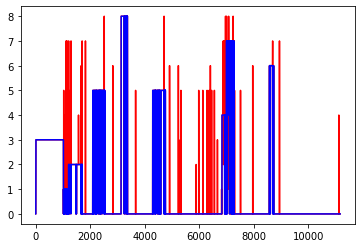

In [ ]:
# test model on testing data 
yhat = model.predict(x_test)
y_pred = []
for k in range (0,len(yhat)):
    yh = np.argmax(yhat[k])
    y_pred.append(yh)
plt.figure(0)
plt.plot(y_pred,'r', y_test,'b')  


ACCURACY 0.9742258815106497
F1-SCORE 0.952755905511811
FALSE POS. RATE (FPR) 0.032484848484848484
RECALL (TPR) 0.9931600547195623


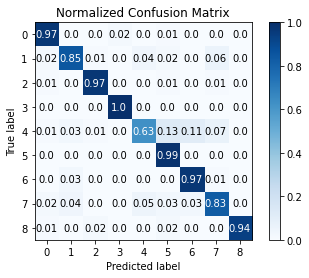

In [ ]:
TP=TN=FP=FN=0
for k in range (0,len(yhat)):
    ylabel     = y_test[k];
    ypredicted = y_pred[k];
    if ypredicted == 0 and ylabel == 0:
        TN = TN + 1
    elif ypredicted > 0 and ylabel > 0:
        TP = TP + 1
    elif ypredicted > 0 and ylabel == 0:
        FP = FP + 1
    elif ypredicted == 0 and ylabel > 0:
        FN = FN + 1
    else:
        print('any')
print("ACCURACY", (TP+TN)/(TP+TN+FP+FN))
print("F1-SCORE", (2*TP)/(2*TP+FP+FN))
print("FALSE POS. RATE (FPR)", (FP)/(FP+TN))
print("RECALL (TPR)", (TP)/(TP+FN))

skplt.metrics.plot_confusion_matrix(y_test,y_pred,normalize="True")

In [ ]:
accuracy_tb = metrics.accuracy_score(y_test, y_pred)
print(accuracy_tb)
precision_recall_fscore_support(y_test, y_pred, average='micro')

In [ ]:
model.save('/content/drive/My Drive/Universidad/Semestre 9/Tesina/modelos')

***************************************************************
EVALUATE MODEL ON TESTING DATA
350/350 [==============================] - 1s 3ms/step - loss: 0.2932 - sparse_categorical_accuracy: 0.9835
***************************************************************
Assessment: 2 classes
Accuracy 0.9942724181134777
Precision 0.9943172672622926
F1-SCORE 0.9942830584883344
RECALL (TPR) 0.9942724181134777
FALSE POS. RATE (FPR) 0.00593939393939394
***************************************************************
Assessment: n classes
Accuracy 0.9835332020762484
Precision 0.9840236273812822
F1-SCORE 0.9835902355226822
RECALL (TPR) 0.9835332020762484


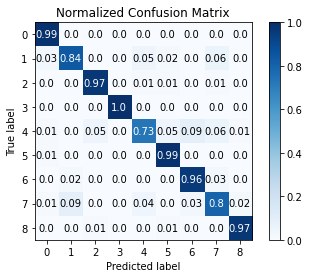

In [ ]:
from sklearn.metrics import accuracy_score, recall_score,f1_score,precision_score,roc_auc_score
print("***************************************************************")
print("EVALUATE MODEL ON TESTING DATA")
results = model.evaluate(x_test, y_test)
yhat = model.predict(x_test)
yyhat = []
for k in range (0,len(yhat)):
    yh = np.argmax(yhat[k])
    yyhat.append(yh)
print("***************************************************************")    
print("Assessment: 2 classes") 
TP=TN=FP=FN=0
y_test2c = np.array(y_test)
y_test2c [y_test2c>=1] = 1;
y_hat2c = np.array(yyhat)
y_hat2c [y_hat2c>=1] = 1;
print("Accuracy", accuracy_score(y_test2c, y_hat2c))
print("Precision", precision_score(y_test2c, y_hat2c, average='weighted'))
print("F1-SCORE", f1_score(y_test2c, y_hat2c, average='weighted'))
print("RECALL (TPR)", recall_score(y_test2c, y_hat2c, average='weighted'))
 
for k in range (0,len(yhat)):
    ylabel     = y_test[k];
    ypredicted = yyhat[k];
    if ypredicted == 0 and ylabel == 0:
        TN = TN + 1
    elif ypredicted > 0 and ylabel > 0:
        TP = TP + 1
    elif ypredicted > 0 and ylabel == 0:
        FP = FP + 1
    elif ypredicted == 0 and ylabel > 0:
        FN = FN + 1
    else:
        print('any')
# print("ACCURACY", (TP+TN)/(TP+TN+FP+FN))
# print("Precision ", (TP)/(TP+FP))
# print("F1-SCORE", (2*TP)/(2*TP+FP+FN))
# print("RECALL (TPR)", (TP)/(TP+FN))
print("FALSE POS. RATE (FPR)", (FP)/(FP+TN))


print("***************************************************************") 
print("Assessment: n classes") 
print("Accuracy", accuracy_score(y_test, yyhat))
print("Precision", precision_score(y_test, yyhat, average='weighted'))
print("F1-SCORE", f1_score(y_test, yyhat, average='weighted'))
print("RECALL (TPR)", recall_score(y_test, yyhat, average='weighted'))

skplt.metrics.plot_confusion_matrix(y_test,yyhat,normalize="True")

# Time complexity Analysis



In [19]:
import timeit

def prediction():
  yhat = model.predict(x_test[0:10000]);

# load model and testing data

execution_time = timeit.repeat(prediction, number=1, repeat=100)
print('Average Flow/s: ', 1/((min(execution_time))/10000))



Average Flow/s:  13298.739853302957


In [18]:
y = x_test[0:10000]
y.shape

(10000, 5, 49)